# Jessica's Charts

In [1]:
import sys
import os
import altair as alt
import pandas as pd
from toolz.curried import pipe

# # Create a new data transformer that stores the files in a directory
def json_dir(data, data_dir='altairdata'):
    os.makedirs(data_dir, exist_ok=True)
    return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}') )

# # Register and enable the new transformer
alt.data_transformers.register('json_dir', json_dir)
alt.data_transformers.enable('json_dir')

sys.path.append('..')
from scripts import wrangle_and_clean as wac

# Handle large data sets (default shows only 5000)
# See here: https://altair-viz.github.io/user_guide/data_transformers.html
alt.data_transformers.disable_max_rows()

alt.renderers.enable('jupyterlab')

RendererRegistry.enable('jupyterlab')

In [2]:
mxmh = wac.clean_data("../data/raw/mxmh_survey_results.csv")
mxmh.head()

,Timestamp,Age,Primary streaming service,Hours per day,While working,Instrumentalist,Composer,Fav genre,Exploratory,Foreign languages,...,Anxiety_Level,Depression_Level,Insomnia_Level,OCD_Level,Date,Time,Time of Day,Musical_hobbies,Age_Grouped,Genre Diversity Score
0,2022-08-27 19:29:02,18.0,Spotify,3.0,Yes,Yes,Yes,Latin,Yes,Yes,...,Low,Low,Low,Low,2022-08-27,19:29:02,Evening,Yes,18.0,10
1,2022-08-27 19:57:31,63.0,Pandora,1.5,Yes,No,No,Rock,Yes,No,...,High,Low,Low,Low,2022-08-27,19:57:31,Evening,No,63.0,13
2,2022-08-27 21:28:18,18.0,Spotify,4.0,No,No,No,Video game music,No,Yes,...,High,High,High,Low,2022-08-27,21:28:18,Evening,No,18.0,10
3,2022-08-27 21:40:40,61.0,YouTube Music,2.5,Yes,No,Yes,Jazz,Yes,Yes,...,High,High,Low,Low,2022-08-27,21:40:40,Evening,Yes,61.0,9
4,2022-08-27 21:54:47,18.0,Spotify,4.0,Yes,No,No,R&B,Yes,No,...,High,Low,Medium,High,2022-08-27,21:54:47,Evening,No,18.0,10


## What is the distribution of self-reported mental health scores based on opinions of music on mental health?

In [3]:
mxmh_scores = mxmh.melt(id_vars=["Timestamp", "Age", "Music effects"], 
                     value_vars=["Anxiety", "Depression", "Insomnia", "OCD"], 
                     var_name="Mental Health Condition", 
                     value_name="Self-report Score")
# mxmh_scores.head()

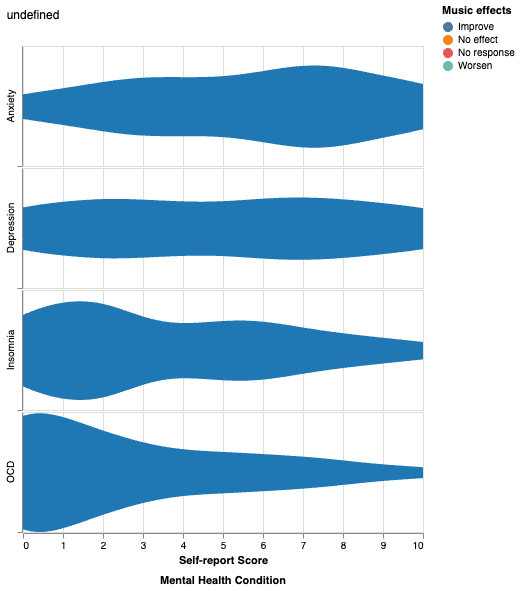

In [4]:
bind_checkbox = alt.binding_checkbox(name='Split Distribution by Opinion on Mudic for Mental Health Improvement: ')
param_checkbox = alt.param(bind=bind_checkbox)

# Create a violin plot
violin = alt.Chart(mxmh_scores, width=100).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    x=alt.X('Self-report Score:Q'),
    y=alt.Y('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    row=alt.Row('Mental Health Condition:N')
        .spacing(0)
        .header(titleOrient='bottom', labelOrient='left', labelPadding=0),
    color=alt.condition(param_checkbox, 'Music effects:N', alt.value("#1f77b4")),
).properties(width=400, height=120).add_params(param_checkbox)

alt.vconcat(alt.Chart().mark_text(align='center',
                                  fontSize=12,
    ).encode(text="Split Distribution by Opinion on Music for Mental Health Improvement:N").add_params(param_checkbox),
    violin
)

In [5]:
# Create a boxplot
boxplot = alt.Chart(mxmh_scores).mark_boxplot(box={'stroke': 'black'}, size=40, opacity=0.8).encode(
    y=alt.Y('Mental Health Condition:N', title=""),
    x=alt.X('Self-report Score:Q', title="Self-report Score"),
    # color=alt.Color("Mental Health Condition:N", legend=None),
    tooltip=["Self-report Score", "Mental Health Condition"]
).properties(width=400, height=400)


# violin | boxplot

In [6]:
selection = alt.selection_point()

violin_select = alt.Chart(mxmh_scores, width=100).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    x=alt.X('Self-report Score:Q'),
    y=alt.Y('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    row=alt.Row('Mental Health Condition:N'),
    color=alt.condition(selection, 'Music effects:N', alt.value('grey')),
).properties(width=400, height=120).add_params(selection)

# violin_select.show()

In [7]:
test_boxplot = alt.Chart(mxmh).mark_boxplot(box={'stroke': 'black'}, size=40, opacity=0.8).encode(
    alt.Y(alt.repeat(), title="", type="quantitative"),
    # x=alt.X('', title="Self-report Score"),
    # color=alt.Color("Mental Health Condition:N", legend=None),
    # tooltip=[]
).properties(height=150).repeat(['Anxiety', 'Depression', 'Insomnia', 'OCD'], columns=1)
# test_boxplot

In [8]:
# Create a violin plot
violin = alt.Chart(mxmh_scores).transform_density(
    'Self-report Score',
    as_=['Self-report Score', 'density'],
    extent=[-0, 10],
    groupby=['Mental Health Condition', "Music effects"]
).mark_area(orient='vertical').encode(
    y=alt.Y('density:Q')
        .stack('center')
        .impute(None)
        .title(None)
        .axis(labels=False, values=[0], grid=False, ticks=True),
    x=alt.X('Self-report Score:Q')
)

# Create a boxplot
boxplot = alt.Chart(mxmh_scores).mark_boxplot(box={'stroke': 'black'}, size=40, opacity=0.8).encode(
    y=alt.Y('Mental Health Condition:N', title=""),
    x=alt.X('Self-report Score:Q', title="Self-report Score"),
    color=alt.Color("Mental Health Condition:N", legend=None),
    tooltip=["Mental Health Condition", "Self-report Score"]
).properties(width=400, height=400)

# Layer both plots
final_chart = alt.hconcat(violin, boxplot).resolve_scale(x='shared')

# final_chart.show()

# What are the patterns and anomalies in self-reported mental health severities?

In [9]:
mxmh_scores

,Timestamp,Age,Music effects,Mental Health Condition,Self-report Score
0,2022-08-27 19:29:02,18.0,No response,Anxiety,3.0
1,2022-08-27 19:57:31,63.0,No response,Anxiety,7.0
2,2022-08-27 21:28:18,18.0,No effect,Anxiety,7.0
3,2022-08-27 21:40:40,61.0,Improve,Anxiety,9.0
4,2022-08-27 21:54:47,18.0,Improve,Anxiety,7.0
...,...,...,...,...,...
2911,2022-10-30 14:37:28,17.0,Improve,OCD,9.0
2912,2022-11-01 22:26:42,18.0,Improve,OCD,5.0
2913,2022-11-03 23:24:38,19.0,Improve,OCD,2.0
2914,2022-11-04 17:31:47,19.0,Improve,OCD,1.0


In [10]:
# # Create a parameter, checkbox
# selection = alt.selection_point()

# # Create a violin plot
# multibar = alt.Chart(mxmh_scores).mark_bar().encode(
#     x='Self-report Score:O',
#     y='count():Q',
#     color='Mental Health Condition:N',
# )

# # Create a boxplot
# dotplot = alt.Chart(mxmh_scores).add_params(
#     selection
# ).mark_point(size=40, opacity=0.8).encode(
#     x=alt.X('Self-report Score:Q', title="Self-report Score"),
#     y=alt.Y('Mental Health Condition:N', title="Mental Health Condition"),
#     # color=alt.Color("Mental Health Condition:N", legend=None),
#     color=alt.condition(selection, 'Mental Health Condition:N', alt.value('grey')),
#     # opacity=alt.condition(selection, alt.value(0.8), alt.value(0.1)),
#     size = alt.Size("count():Q"),
#     tooltip=["Mental Health Condition", "Self-report Score", "count()"]
# ).properties(width=400, height=300)

# multibar | dotplot

In [11]:
# Create a brush parameter
# brush = alt.selection_interval(
#     encodings=['x'] # limit selection to x-axis values
# )
# 
# selection = alt.selection_point()

# options = ['Anxiety', 'Depression', 'Insomnia', 'OCD']
# labels = [option + ' ' for option in options]

# input_dropdown = alt.binding_radio(
#     # Add the empty selection which shows all when clicked
#     options=options + [None],
#     labels=labels + ['All'],
#     name='Condition: '
# )
# selection = alt.selection_point(
#     fields=['Mental Health Condition:N'],
#     bind=input_dropdown,
# )

#####

# https://altair-viz.github.io/gallery/multiple_interactions.html#gallery-multiple-interactions
radio = alt.binding_radio(options=['Anxiety', 'Depression', 'Insomnia', 'OCD'] + [None], labels=labels + ['All'])
select = alt.selection_point(fields=['Mental Health Condition:N'], bind=radio)

radio_color = (
    alt.when(select)
    .then(alt.Color("MPAA_Rating:N").legend(None))
    .otherwise(alt.value("lightgray"))
)

#####

# multibar = alt.Chart(mxmh_scores).mark_bar().encode(
#     x='Self-report Score:O',
#     y='count():Q',
#     color=alt.Color('Mental Health Condition:N').scale(domain=options),
# ).add_params(
#     selection
# ).transform_filter(
#     selection
# )

base = alt.Chart(mxmh_scores, width=200, height=200).mark_point(filled=True).encode(
    x=alt.X('Self-report Score:O').scale(domain=(0, 10), clamp=True),
    y='count():Q',
    tooltip="Title:N"
)

highlight_ratings = base.add_params(
    select
).encode(
    color=radio_color
).properties(title="Radio Button Highlighting")

# # Create a boxplot
# dotplot = alt.Chart(mxmh_scores).mark_point(size=40, opacity=0.8).encode(
#     x=alt.X('Self-report Score:Q', scale=alt.Scale(domain=[-0.5, 10.5])),
#     y=alt.Y('Mental Health Condition:N', title="Mental Health Condition"),
#     alt.Color('Mental Health Condition:N').scale(domain=options),
#     # color=alt.Color('Mental Health Condition:N').scale(domain=options),
#     # opacity=alt.condition(brush, alt.value(0.75), alt.value(0.05)),
#     size = alt.Size("count():Q"),
#     tooltip=["Mental Health Condition", "Self-report Score", "count()"]
# ).add_params(
#     selection
# ).transform_filter(
#     selection
# )

multibar

NameError: name 'labels' is not defined

# Question 3

In [ ]:
source = mxmh_scores

dropdown = alt.binding_select(
    options=["Anxiety", "Depression", "Insomnia", "OCD"],
    name='Axis Column'
)
xcol_param = alt.param(
    value='Anxiety',
    bind=dropdown
)

ycol_param = alt.param(
    value='Depression',
    bind=dropdown
)

slider = alt.binding_range(min=0, max=10, step=0.1)
threshold = alt.param(name="threshold", value=5, bind=slider)

alt.layer(
    alt.Chart(source).mark_circle().encode(
        x=alt.X("x:Q").title("Self-reported Score"),
        y=alt.Y("y:Q").title("Self-reported Score")
    )
    ).transform_filter(
        alt.datum["x"] >= threshold
    ),

    alt.Chart(source).mark_circle().encode(
        x=alt.X("x:Q").bin(maxbins=10),
        y=alt.Y("y:Q").bin(maxbins=10),
        size=alt.Size("count():Q").scale(domain=[0,160])
    ).transform_filter(
        alt.datum["x"] < threshold
    ),

    alt.Chart().mark_rule(color="gray").encode(
        strokeWidth=alt.StrokeWidth(value=6),
        x=alt.X(datum=alt.expr(threshold.name), type="quantitative")
    )
).add_params(threshold, xcol_param, ycol_param)